# Bengali.AI SEResNeXt training with pytorch

I will introduce following contents

 - **Fast data loading** with feather format
 - **Data augmentation** technic with affine transformation
 - **CNN SoTA models**: Use pytorch `pretrainedmodels` library, especially I use **`SEResNeXt`** in this notebook
 - **Training code abstraction**: Use `pytorch-ignite` module for the trainining abstraction
 
### Update history

 - 2020/1/4 v2: Added albumentations augmentations introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)

# Table of Contents:
**[Fast data loading with feather](#load)**<br>
**[Dataset](#dataset)**<br>
**[Data augmentation/processing](#processing)**<br>
**[pytorch model & define classifier](#model)**<br>
**[Training code](#train)**<br>
**[Prediction](#pred)**<br>
**[Reference and further reading](#ref)**<br>

To install https://github.com/Cadene/pretrained-models.pytorch without internet connection, we can install library as "dataset".

It is uploaded by @rishabhiitbhu : https://www.kaggle.com/rishabhiitbhu/pretrainedmodels

In [1]:
!pip install ../input/pretrainedmodels/pretrainedmodels-0.7.4/ > /dev/null # no output

지정된 경로를 찾을 수 없습니다.


In [2]:
import gc
import os
from pathlib import Path
import random
import sys

from tqdm.notebook import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.display import display, HTML

# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff

# --- models ---
from sklearn import preprocessing
from sklearn.model_selection import KFold
# import lightgbm as lgb
# import xgboost as xgb
# import catboost as cb

# --- setup ---
pd.set_option('max_columns', 50)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

../input\bengaliai-cv19\class_map.csv
../input\bengaliai-cv19\sample_submission.csv
../input\bengaliai-cv19\test.csv
../input\bengaliai-cv19\test_image_data_0.parquet
../input\bengaliai-cv19\test_image_data_1.parquet
../input\bengaliai-cv19\test_image_data_2.parquet
../input\bengaliai-cv19\test_image_data_3.parquet
../input\bengaliai-cv19\train.csv
../input\bengaliai-cv19\train_image_data_0.parquet
../input\bengaliai-cv19\train_image_data_1.parquet
../input\bengaliai-cv19\train_image_data_2.parquet
../input\bengaliai-cv19\train_image_data_3.parquet
../input\bengaliaicv19feather\test_image_data_0.feather
../input\bengaliaicv19feather\test_image_data_1.feather
../input\bengaliaicv19feather\test_image_data_2.feather
../input\bengaliaicv19feather\test_image_data_3.feather
../input\bengaliaicv19feather\train_image_data_0.feather
../input\bengaliaicv19feather\train_image_data_1.feather
../input\bengaliaicv19feather\train_image_data_2.feather
../input\bengaliaicv19feather\train_image_data_3.f

In [4]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load in 

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the "../input/" directory.
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # Any results you write to the current directory are saved as output.

In [5]:
debug=False
submission=False
batch_size=32*4
device='cuda:0'
out='.'
image_size=64*2
arch='pretrained'
model_name='densenet121'

In [6]:
import json

data = {
    "image_size": image_size,
    "threshold": 20.0,
    "arch": "pretrained",
    "model_name": model_name
}

In [7]:
with open(r'./save/args.json', 'w') as f:
    json.dump(data, f, indent=4)

In [8]:
datadir = Path('../input/bengaliai-cv19')
featherdir = Path('../input/bengaliaicv19feather')
outdir = Path('./save')

In [9]:
# Read in the data CSV files
# train = pd.read_csv(datadir/'train.csv')
# test = pd.read_csv(datadir/'test.csv')
# sample_submission = pd.read_csv(datadir/'sample_submission.csv')
# class_map = pd.read_csv(datadir/'class_map.csv')

# Fast data loading with feather

Refer [Bengali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bengali-ai-super-fast-data-loading-with-feather) and [dataset](https://www.kaggle.com/corochann/bengaliaicv19feather) for detail.<br/>
Original `parquet` format takes about 60 sec to load 1 data, while `feather` format takes about **2 sec to load 1 data!!!**

### How to add dataset

When you write kernel, click "+ Add Data" botton on right top.<br/>
Then inside window pop-up, you can see "Search Datasets" text box on right top.<br/>
You can type "bengaliai-cv19-feather" to find this dataset and press "Add" botton to add the data.

In [10]:
import numpy as np
import pandas as pd
import gc


def prepare_image(datadir, featherdir, data_type='train',
                  submission=False, indices=[0, 1, 2, 3]):
    assert data_type in ['train', 'test']
    if submission:
        image_df_list = [pd.read_parquet(datadir / f'{data_type}_image_data_{i}.parquet')
                         for i in indices]
    else:
        image_df_list = [pd.read_feather(featherdir / f'{data_type}_image_data_{i}.feather')
                         for i in indices]

    print('image_df_list', len(image_df_list))
    HEIGHT = 137
    WIDTH = 236
    images = [df.iloc[:, 1:].values.reshape(-1, HEIGHT, WIDTH) for df in image_df_list]
    del image_df_list
    gc.collect()
    images = np.concatenate(images, axis=0)
    return images


In [11]:
featherdir

WindowsPath('../input/bengaliaicv19feather')

In [12]:
%%time

train = pd.read_csv(datadir/'train.csv')
train_labels = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].values
indices = [0] if debug else [0, 1, 2, 3]
train_images = prepare_image(
    datadir, featherdir, data_type='train', submission=False, indices=indices)

image_df_list 4
Wall time: 14.1 s


<a id="dataset"></a>
# Dataset

In [13]:
"""
Referenced `chainer.dataset.DatasetMixin` to work with pytorch Dataset.
"""
import numpy
import six
import torch
from torch.utils.data.dataset import Dataset


class DatasetMixin(Dataset):

    def __init__(self, transform=None):
        self.transform = transform

    def __getitem__(self, index):
        """Returns an example or a sequence of examples."""
        if torch.is_tensor(index):
            index = index.tolist()
        if isinstance(index, slice):
            current, stop, step = index.indices(len(self))
            return [self.get_example_wrapper(i) for i in
                    six.moves.range(current, stop, step)]
        elif isinstance(index, list) or isinstance(index, numpy.ndarray):
            return [self.get_example_wrapper(i) for i in index]
        else:
            return self.get_example_wrapper(index)

    def __len__(self):
        """Returns the number of data points."""
        raise NotImplementedError

    def get_example_wrapper(self, i):
        """Wrapper of `get_example`, to apply `transform` if necessary"""
        example = self.get_example(i)
        if self.transform:
            example = self.transform(example)
        return example

    def get_example(self, i):
        """Returns the i-th example.

        Implementations should override it. It should raise :class:`IndexError`
        if the index is invalid.

        Args:
            i (int): The index of the example.

        Returns:
            The i-th example.

        """
        raise NotImplementedError


This `DatasetMixin` class can be used to define any custom dataset class in pytorch. We can implement `get_example(self, i)` method to return `i`-th data.

Here I return i-th image `x` and `label`, with scaling image to be value ranges between 0~1.

In [14]:
import numpy as np
import cv2

class BengaliAIDataset(DatasetMixin):
    def __init__(self, images, labels=None, transform=None, indices=None):
        super(BengaliAIDataset, self).__init__(transform=transform)
        self.images = images
        self.labels = labels
        if indices is None:
            indices = np.arange(len(images))
        self.indices = indices
        self.train = labels is not None

    def __len__(self):
        """return length of this dataset"""
        return len(self.indices)

    def get_example(self, i):
        """Return i-th data"""
        i = self.indices[i]
        x = self.images[i]
        # Opposite white and black: background will be white and
        # for future Affine transformation
        x = (255 - x).astype(np.float32) / 255.
        
        
        #x = x.astype(np.float32) / 255.
        #x = x.astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_GRAY2BGR)
        x = x.astype(np.double)
        
        if self.train:
            y = self.labels[i]
            return x, y
        else:
            return x


Let's see how this `BengaliAIDataset` work

`train_dataset[i]` returns i-th image array and 3 target labels (graphme_root, vowel_diacritic and consonant_diacritic).

In [15]:
train_dataset = BengaliAIDataset(train_images, train_labels)

image, label = train_dataset[0]
print('image', image.shape, 'label', label)

image (137, 236, 3) label [15  9  5]


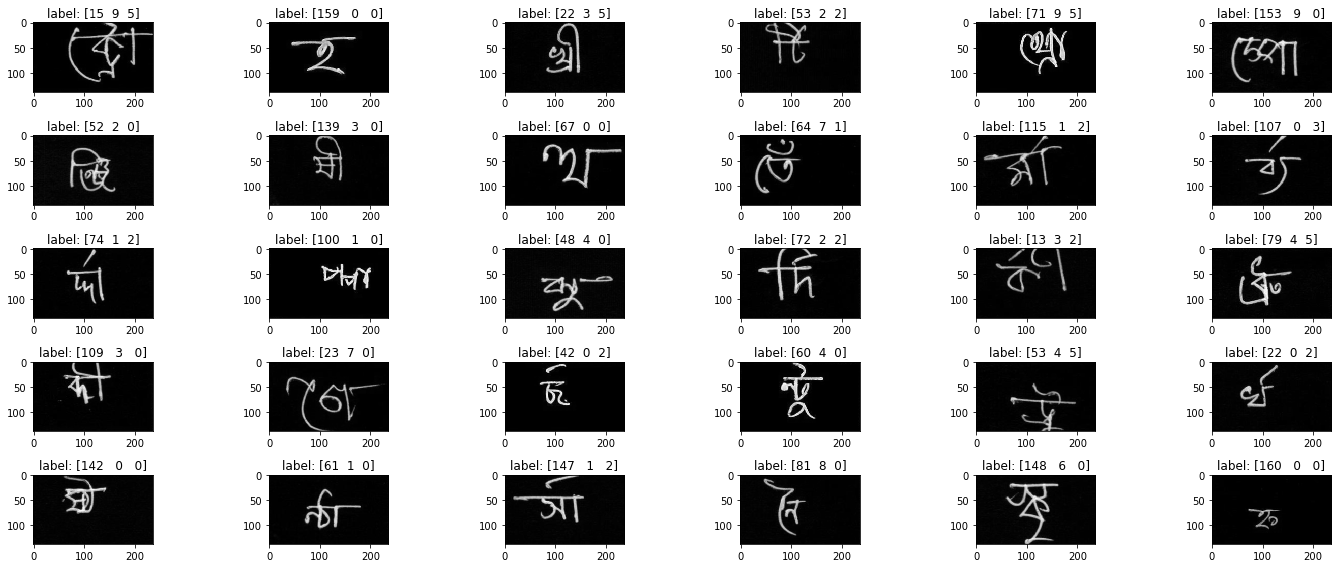

<Figure size 432x288 with 0 Axes>

In [16]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

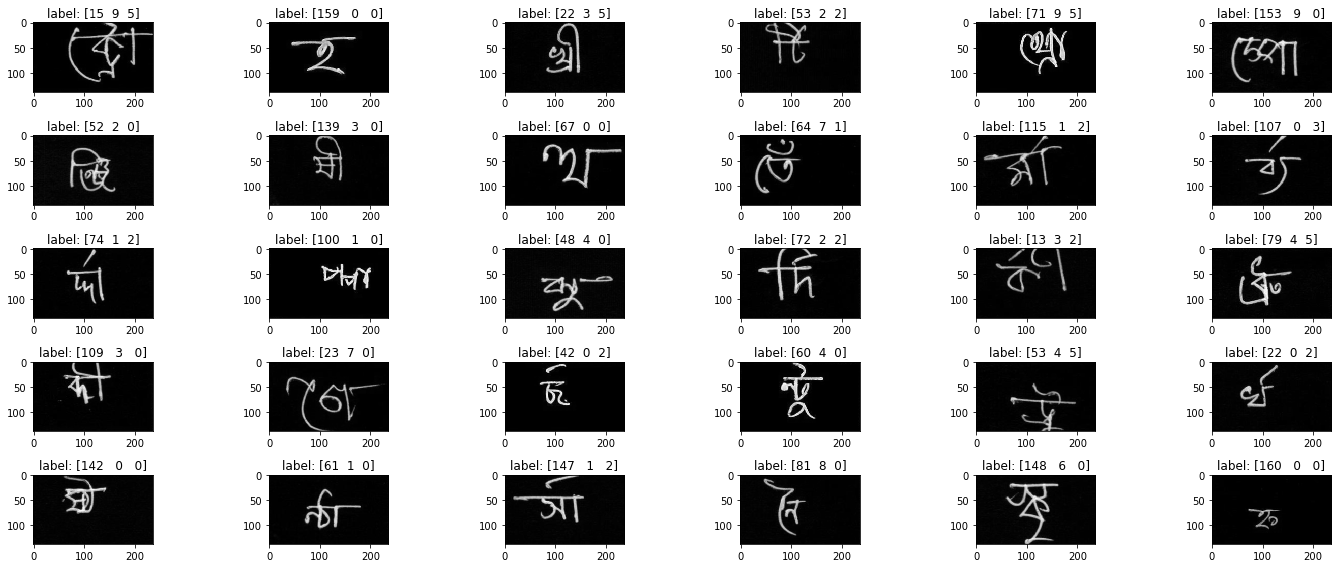

<Figure size 432x288 with 0 Axes>

In [17]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()
plt.savefig('bengaliai.png')

<a id="processing"></a>
# Data augmentation/processing

For CNN training, data augmentation is important to improve test accuracy (generalization performance). I will show some image preprocessing to increase the data variety.

In [18]:
"""
From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
"""
import cv2
from skimage.transform import AffineTransform, warp
import numpy as np


def affine_image(img):
    """

    Args:
        img: (h, w) or (1, h, w)

    Returns:
        img: (h, w)
    """
    # ch, h, w = img.shape
    # img = img / 255.
    #if img.ndim == 3:
    #    img = img[0]

    # --- scale ---
    min_scale = 0.8
    max_scale = 1.2
    sx = np.random.uniform(min_scale, max_scale)
    sy = np.random.uniform(min_scale, max_scale)

    # --- rotation ---
    max_rot_angle = 15 #7
    rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

    # --- shear ---
    max_shear_angle = 10
    shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

    # --- translation ---
    max_translation = 4
    tx = np.random.randint(-max_translation, max_translation)
    ty = np.random.randint(-max_translation, max_translation)

    tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
                            translation=(tx, ty))
    transformed_image = warp(img, tform)
    #assert transformed_image.ndim == 2
    return transformed_image


from scipy.ndimage.measurements import label

def connected_comp(array):
    
    structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
    labeled, ncomponents = label(array, structure)
    
    valid = []
    for i in range(1,ncomponents+1):
        if np.sum(labeled == i)>10:
            valid.append(i)

    new_array = np.zeros(array.shape)
    for i in valid:
        new_array += labeled==i
    return new_array

def crop_char_image(image, threshold=5./255.):
    #assert image.ndim == 2
    is_black = np.copy(image[:,:,0])
    is_black = is_black > threshold
    is_black[:4,:] = 0
    is_black[-4:,:] = 0
    is_black[:,:4] = 0
    is_black[:,-4:] = 0

    #is_black = connected_comp(is_black)

    is_black_vertical = np.sum(is_black, axis=0) > 0
    is_black_horizontal = np.sum(is_black, axis=1) > 0
    
    left = np.argmax(is_black_horizontal)-4
    right = np.argmax(is_black_horizontal[::-1])+4
    top = np.argmax(is_black_vertical)+4
    bottom = np.argmax(is_black_vertical[::-1])-4
    height, width, _ = image.shape
    cropped_image = image[left:height - right, top:width - bottom, :]
    return cropped_image


def resize(image, size=(128, 128)):
    return cv2.resize(image, size)

## Affine transformation for data augmentation

To increase validation score, the number of training data is important. When we can use more number of training data, we can reduce overfitting and validation score becomes high.

"Data augmentation" is a technic to virtually create extra training data, based on the given training data. For this MNIST task, data augmentation can be achieved by utilizing affine transformation.

1. Rotation AffineTransformation
2. Translation
3. Scale
4. Shear

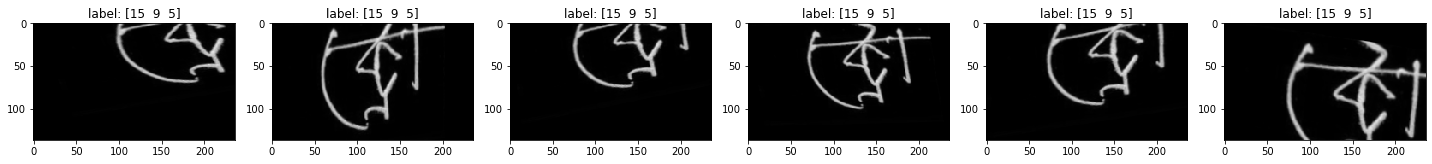

In [19]:
nrow, ncol = 1, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[0]
    ax.imshow(affine_image(image), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

When the image is slightly rotated, shifted (transformed) or scaled, the image looks like the same label. We can virtually create another image data from one image in such a way.

## crop image

Here I crop image

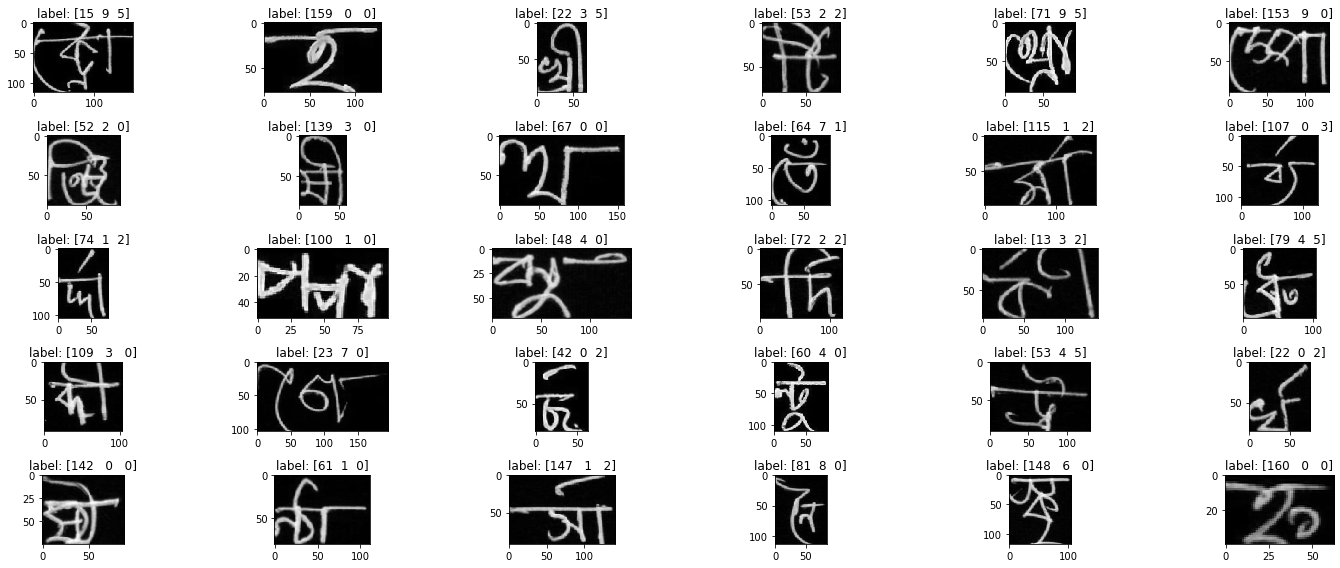

In [20]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(crop_char_image(image, threshold=20./255.), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

## resize image

We need to resize image after crop, to align image size for CNN batch training.

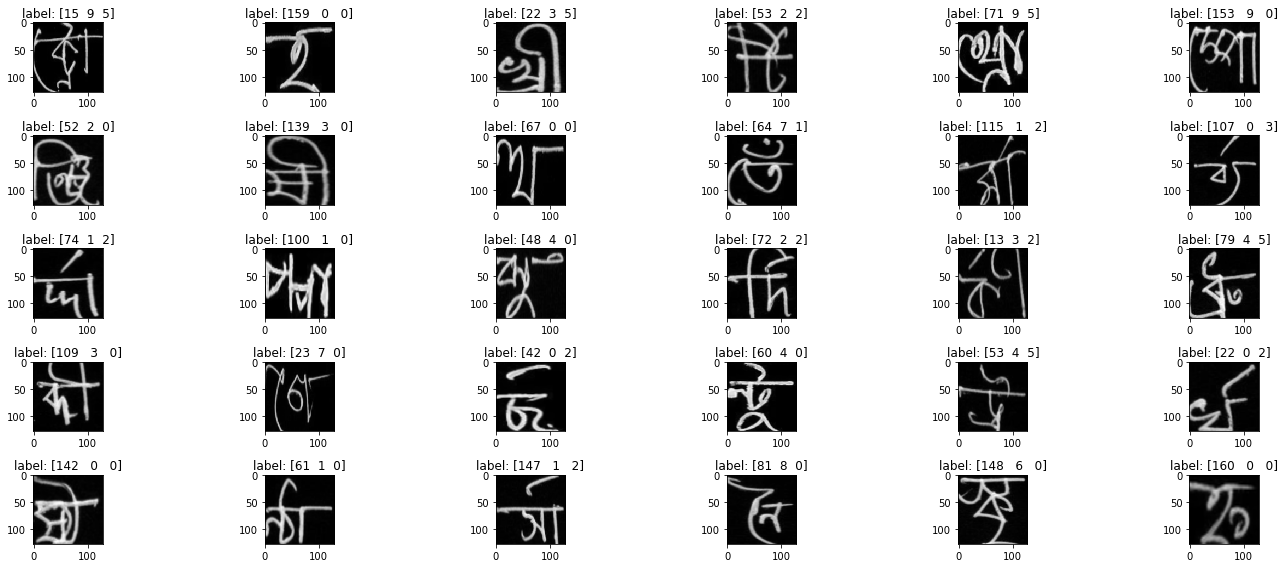

In [21]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label2 = train_dataset[i]
    ax.imshow(resize(crop_char_image(image, threshold=20./255.)), cmap='Greys')
    ax.set_title(f'label: {label2}')
plt.tight_layout()

Put everything together with `Transform` class. <br>
[Update] I added **albumentations augmentations** introduced in [Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial).

In [22]:
import albumentations as A
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


def _evaluate_ratio(ratio):
    if ratio <= 0.:
        return False
    return np.random.uniform() < ratio


def apply_aug(aug, image):
    return aug(image=image)['image']


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
                 grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
                 piece_affine_ratio=0., ssr_ratio=0.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

        self.blur_ratio = blur_ratio
        self.noise_ratio = noise_ratio
        self.cutout_ratio = cutout_ratio
        self.grid_distortion_ratio = grid_distortion_ratio
        self.elastic_distortion_ratio = elastic_distortion_ratio
        self.random_brightness_ratio = random_brightness_ratio
        self.piece_affine_ratio = piece_affine_ratio
        self.ssr_ratio = ssr_ratio

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)

        # albumentations...
        x = x.astype(np.double)
        #assert x.ndim == 2
        # 1. blur
        if _evaluate_ratio(self.blur_ratio):
            r = np.random.uniform()
            if r < 0.25:
                x = apply_aug(A.Blur(p=1.0), x)
            elif r < 0.5:
                x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
            elif r < 0.75:
                x = apply_aug(A.GaussianBlur(p=1.0), x)
            else:
                x = apply_aug(A.MotionBlur(p=1.0), x)

        if _evaluate_ratio(self.noise_ratio):
            r = np.random.uniform()
            if r < 0.50:
                x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
            else:
                x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

        if _evaluate_ratio(self.cutout_ratio):
            # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
            x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

        if _evaluate_ratio(self.grid_distortion_ratio):
            x = apply_aug(A.GridDistortion(p=1.0), x)

        if _evaluate_ratio(self.elastic_distortion_ratio):
            x = apply_aug(A.ElasticTransform(
                sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

        if _evaluate_ratio(self.random_brightness_ratio):
            # A.RandomBrightness(p=1.0)  # Deprecated...
            # A.RandomContrast(p=1.0)    # Deprecated...
            x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

        if _evaluate_ratio(self.piece_affine_ratio):
            x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

        if _evaluate_ratio(self.ssr_ratio):
            x = apply_aug(A.ShiftScaleRotate(
                shift_limit=0.0625,
                scale_limit=0.1,
                rotate_limit=30,
                p=1.0), x)

        if self.normalize:
            x = (x.astype(np.double) - 0.0692) / 0.2051
            
            
        #if x.ndim == 2:
        #    x = x[None, :, :]
        x = np.einsum('ijk->kij', x)
        
        x = x.astype(np.double)
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x
        
# class Transform:
#     def __init__(self, affine=True, crop=True, size=(64, 64),
#                  normalize=True, train=True, threshold=40.,
#                  sigma=-1., blur_ratio=0., noise_ratio=0., cutout_ratio=0.,
#                  grid_distortion_ratio=0., elastic_distortion_ratio=0., random_brightness_ratio=0.,
#                  piece_affine_ratio=0., ssr_ratio=0.):
#         self.affine = affine
#         self.crop = crop
#         self.size = size
#         self.normalize = normalize
#         self.train = train
#         self.threshold = threshold / 255.
#         self.sigma = sigma / 255.

#         self.blur_ratio = blur_ratio
#         self.noise_ratio = noise_ratio
#         self.cutout_ratio = cutout_ratio
#         self.grid_distortion_ratio = grid_distortion_ratio
#         self.elastic_distortion_ratio = elastic_distortion_ratio
#         self.random_brightness_ratio = random_brightness_ratio
#         self.piece_affine_ratio = piece_affine_ratio
#         self.ssr_ratio = ssr_ratio

#     def __call__(self, example):
#         if self.train:
#             x, y = example
#         else:
#             x = example
#         # --- Augmentation ---
#         if self.affine:
#             x = affine_image(x)

#         # --- Train/Test common preprocessing ---
#         if self.crop:
#             x = crop_char_image(x, threshold=self.threshold)
#         if self.size is not None:
#             x = resize(x, size=self.size)
#         if self.sigma > 0.:
#             x = add_gaussian_noise(x, sigma=self.sigma)

#         # albumentations...
#         x = x.astype(np.float32)
#         assert x.ndim == 2
#         # 1. blur
#         if _evaluate_ratio(self.blur_ratio):
#             r = np.random.uniform()
#             if r < 0.25:
#                 x = apply_aug(A.Blur(p=1.0), x)
#             elif r < 0.5:
#                 x = apply_aug(A.MedianBlur(blur_limit=5, p=1.0), x)
#             elif r < 0.75:
#                 x = apply_aug(A.GaussianBlur(p=1.0), x)
#             else:
#                 x = apply_aug(A.MotionBlur(p=1.0), x)

#         if _evaluate_ratio(self.noise_ratio):
#             r = np.random.uniform()
#             if r < 0.50:
#                 x = apply_aug(A.GaussNoise(var_limit=5. / 255., p=1.0), x)
#             else:
#                 x = apply_aug(A.MultiplicativeNoise(p=1.0), x)

#         if _evaluate_ratio(self.cutout_ratio):
#             # A.Cutout(num_holes=2,  max_h_size=2, max_w_size=2, p=1.0)  # Deprecated...
#             x = apply_aug(A.CoarseDropout(max_holes=8, max_height=8, max_width=8, p=1.0), x)

#         if _evaluate_ratio(self.grid_distortion_ratio):
#             x = apply_aug(A.GridDistortion(p=1.0), x)

#         if _evaluate_ratio(self.elastic_distortion_ratio):
#             x = apply_aug(A.ElasticTransform(
#                 sigma=50, alpha=1, alpha_affine=10, p=1.0), x)

#         if _evaluate_ratio(self.random_brightness_ratio):
#             # A.RandomBrightness(p=1.0)  # Deprecated...
#             # A.RandomContrast(p=1.0)    # Deprecated...
#             x = apply_aug(A.RandomBrightnessContrast(p=1.0), x)

#         if _evaluate_ratio(self.piece_affine_ratio):
#             x = apply_aug(A.IAAPiecewiseAffine(p=1.0), x)

#         if _evaluate_ratio(self.ssr_ratio):
#             x = apply_aug(A.ShiftScaleRotate(
#                 shift_limit=0.0625,
#                 scale_limit=0.1,
#                 rotate_limit=30,
#                 p=1.0), x)

#         if self.normalize:
#             x = (x.astype(np.float32) - 0.0692) / 0.2051
#         if x.ndim == 2:
#             x = x[None, :, :]
#         x = x.astype(np.float32)
#         if self.train:
#             y = y.astype(np.int64)
#             return x, y
#         else:
#             return x
        

In [23]:
train_transform = Transform(
    size=(image_size, image_size), threshold=20.,
    sigma=-1., blur_ratio=0.2, noise_ratio=0.2, cutout_ratio=0.2,
    grid_distortion_ratio=0.2, random_brightness_ratio=0.2,
    piece_affine_ratio=0.2, ssr_ratio=0.2)
# transform = Transform(size=(image_size, image_size)
train_dataset = BengaliAIDataset(train_images, train_labels,
                                 transform=train_transform)

By setting `transform`, its function is called **every time** when we access to the index. Dataset returns different `image` every time! which is useful for training with data augmentation.

In [24]:
# nrow, ncol = 1, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 2))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[0]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

Let's final check the processed images, which will be trained by the model.

In [25]:
# nrow, ncol = 5, 6

# fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
# axes = axes.flatten()
# for i, ax in tqdm(enumerate(axes)):
#     image, label = train_dataset[i]
#     ax.imshow(image[0], cmap='Greys')
#     ax.set_title(f'label: {label}')
# plt.tight_layout()

<a id="model"></a> 
# pytorch model & define classifier

In [26]:
import torch


def residual_add(lhs, rhs):
    lhs_ch, rhs_ch = lhs.shape[1], rhs.shape[1]
    if lhs_ch < rhs_ch:
        out = lhs + rhs[:, :lhs_ch]
    elif lhs_ch > rhs_ch:
        out = torch.cat([lhs[:, :rhs_ch] + rhs, lhs[:, rhs_ch:]], dim=1)
    else:
        out = lhs + rhs
    return out


In [27]:
from typing import List

import torch
from torch import nn
from torch.nn.parameter import Parameter


class LazyLoadModule(nn.Module):
    """Lazy buffer/parameter loading using load_state_dict_pre_hook

    Define all buffer/parameter in `_lazy_buffer_keys`/`_lazy_parameter_keys` and
    save buffer with `register_buffer`/`register_parameter`
    method, which can be outside of __init__ method.
    Then this module can load any shape of Tensor during de-serializing.

    Note that default value of lazy buffer is torch.Tensor([]), while lazy parameter is None.
    """
    _lazy_buffer_keys: List[str] = []     # It needs to be override to register lazy buffer
    _lazy_parameter_keys: List[str] = []  # It needs to be override to register lazy parameter

    def __init__(self):
        super(LazyLoadModule, self).__init__()
        for k in self._lazy_buffer_keys:
            self.register_buffer(k, torch.tensor([]))
        for k in self._lazy_parameter_keys:
            self.register_parameter(k, None)
        self._register_load_state_dict_pre_hook(self._hook)

    def _hook(self, state_dict, prefix, local_metadata, strict, missing_keys,
             unexpected_keys, error_msgs):
        for key in self._lazy_buffer_keys:
            self.register_buffer(key, state_dict[prefix + key])

        for key in self._lazy_parameter_keys:
            self.register_parameter(key, Parameter(state_dict[prefix + key]))


In [28]:
import math
import torch
from torch.nn import init
from torch.nn.parameter import Parameter
import torch.nn.functional as F


class LazyLinear(LazyLoadModule):
    """Linear module with lazy input inference

    `in_features` can be `None`, and it is determined at the first time of forward step dynamically.
    """

    __constants__ = ['bias', 'in_features', 'out_features']
    _lazy_parameter_keys = ['weight']

    def __init__(self, in_features, out_features, bias=True):
        super(LazyLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        if bias:
            self.bias = Parameter(torch.Tensor(out_features))
        else:
            self.register_parameter('bias', None)

        if in_features is not None:
            self.weight = Parameter(torch.Tensor(out_features, in_features))
            self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        if self.weight is None:
            self.in_features = input.shape[-1]
            self.weight = Parameter(torch.Tensor(self.out_features, self.in_features))
            self.reset_parameters()

            # Need to send lazy defined parameter to device...
            self.to(input.device)
        return F.linear(input, self.weight, self.bias)

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )


In [29]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [30]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential


class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained='imagenet'):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        
        h = self.conv0(x)
        h = self.base_model.features(h)
        
        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
            
        return h

## Classifier

In [31]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    while lam > 0.9997:
        lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    
    
#     print(lam)
#     print(data.shape)
#     print(indices)
#     print(bbx1, bbx2, bby1, bby2)
    
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def cutmix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def mixup_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    criterion = nn.CrossEntropyLoss(reduction='mean')
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

In [32]:
from albumentations.core.transforms_interface import DualTransform
from albumentations.augmentations import functional as AF

class GridMask(DualTransform):
    """GridMask augmentation for image classification and object detection.
    
    Author: Qishen Ha
    Email: haqishen@gmail.com
    2020/01/29

    Args:
        num_grid (int): number of grid in a row or column.
        fill_value (int, float, lisf of int, list of float): value for dropped pixels.
        rotate ((int, int) or int): range from which a random angle is picked. If rotate is a single int
            an angle is picked from (-rotate, rotate). Default: (-90, 90)
        mode (int):
            0 - cropout a quarter of the square of each grid (left top)
            1 - reserve a quarter of the square of each grid (left top)
            2 - cropout 2 quarter of the square of each grid (left top & right bottom)

    Targets:
        image, mask

    Image types:
        uint8, float32

    Reference:
    |  https://arxiv.org/abs/2001.04086
    |  https://github.com/akuxcw/GridMask
    """

    def __init__(self, num_grid=3, fill_value=0, rotate=0, mode=0, always_apply=False, p=0.5):
        super(GridMask, self).__init__(always_apply, p)
        if isinstance(num_grid, int):
            num_grid = (num_grid, num_grid)
        if isinstance(rotate, int):
            rotate = (-rotate, rotate)
        self.num_grid = num_grid
        self.fill_value = fill_value
        self.rotate = rotate
        self.mode = mode
        self.masks = None
        self.rand_h_max = []
        self.rand_w_max = []

    def init_masks(self, height, width):
        if self.masks is None:
            self.masks = []
            n_masks = self.num_grid[1] - self.num_grid[0] + 1
            for n, n_g in enumerate(range(self.num_grid[0], self.num_grid[1] + 1, 1)):
                grid_h = height / n_g
                grid_w = width / n_g
                this_mask = np.ones((int((n_g + 1) * grid_h), int((n_g + 1) * grid_w))).astype(np.uint8)
                for i in range(n_g + 1):
                    for j in range(n_g + 1):
                        this_mask[
                             int(i * grid_h) : int(i * grid_h + grid_h / 2),
                             int(j * grid_w) : int(j * grid_w + grid_w / 2)
                        ] = self.fill_value
                        if self.mode == 2:
                            this_mask[
                                 int(i * grid_h + grid_h / 2) : int(i * grid_h + grid_h),
                                 int(j * grid_w + grid_w / 2) : int(j * grid_w + grid_w)
                            ] = self.fill_value
                
                if self.mode == 1:
                    this_mask = 1 - this_mask

                self.masks.append(this_mask)
                self.rand_h_max.append(grid_h)
                self.rand_w_max.append(grid_w)

    def apply(self, image, mask, rand_h, rand_w, angle, **params):
        h, w = image.shape[:2]
        mask = AF.rotate(mask, angle) if self.rotate[1] > 0 else mask
        mask = mask[:,:,np.newaxis] if image.ndim == 3 else mask
        image *= mask[rand_h:rand_h+h, rand_w:rand_w+w].astype(image.dtype)
        return image

    def get_params_dependent_on_targets(self, params):
        img = params['image']
        height, width = img.shape[:2]
        self.init_masks(height, width)

        mid = np.random.randint(len(self.masks))
        mask = self.masks[mid]
        rand_h = np.random.randint(self.rand_h_max[mid])
        rand_w = np.random.randint(self.rand_w_max[mid])
        angle = np.random.randint(self.rotate[0], self.rotate[1]) if self.rotate[1] > 0 else 0

        return {'mask': mask, 'rand_h': rand_h, 'rand_w': rand_w, 'angle': angle}

    @property
    def targets_as_params(self):
        return ['image']

    def get_transform_init_args_names(self):
        return ('num_grid', 'fill_value', 'rotate', 'mode')

In [33]:
def GridMask_train(data):
#     indices = torch.randperm(data.size(0))
#     shuffled_data = data[indices]

    GridMaskCom = A.Compose([
    A.OneOf([
        GridMask(num_grid=(3,15), mode=0),
        GridMask(num_grid=(3,15), mode=2),
        GridMask(num_grid=(3,15), rotate=15, mode=0),
        GridMask(num_grid=(3,15), rotate=15, mode=2),
        GridMask(num_grid=(3,15), rotate=30, mode=0),
        GridMask(num_grid=(3,15), rotate=30, mode=2),
    #A.OneOf([
    #    GridMask(num_grid=(7,10), mode=2),        
    #    GridMask(num_grid=(7,10), rotate=15, mode=2),
    #    GridMask(num_grid=(7,10), rotate=30, mode=2)], p=1)
    ], p=0.8)
    ])
    
    img_list = []
    for i in range(data.size(0)):
        img = GridMaskCom(image=np.einsum('ijk->jki', data[i].cpu().numpy()))['image']
        img_list.append(np.einsum('ijk->kij', img))
    return torch.tensor(img_list).cuda()

In [34]:
# for i in range(10):
#     plt.imshow(transforms_train(image=np.einsum('ijk->jki', train_dataset[0][0]))['image'])
#     plt.show()

In [35]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.double)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor.float()
        
        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']
        
    def forward(self, x, y=None):
        
        const = np.random.randint(6)
        if const<2:        
            # mixup
            data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data

        elif const<4:        
            # cutmix
            data, targets = cutmix(x, y[:,0], y[:,1], y[:,2], 0.4)
            x = data
            
        
        else:
            x = GridMask_train(x)
        
        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        if const<4:
            # cutmix or mixup
            targets1, targets2, targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]        
            preds1, preds2, preds3 = preds[0], preds[1], preds[2]
            lam = float(lam)
            loss_grapheme = lam * F.cross_entropy(preds1, targets1) + (1 - lam) * F.cross_entropy(preds1, targets2) 
            loss_vowel = lam * F.cross_entropy(preds2, targets3) + (1 - lam) * F.cross_entropy(preds2, targets4)
            loss_consonant = lam * F.cross_entropy(preds3, targets5) + (1 - lam) * F.cross_entropy(preds3, targets6)
            loss = loss_grapheme + loss_vowel + loss_consonant  
        else:
            loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
            loss_vowel = F.cross_entropy(preds[1], y[:, 1])
            loss_consonant = F.cross_entropy(preds[2], y[:, 2])
            loss = loss_grapheme + loss_vowel + loss_consonant
            
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    
    
    
    def forward_val(self, x, y=None):

        pred = self.predictor(x)
        
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        
        return loss, metrics, pred
    

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                
                pred = self.predictor(batch)
                
                
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels

<a id="train"></a>
# Training code

## prepare data

In [36]:
n_dataset = len(train_images)
train_data_size = 200 if debug else int(n_dataset * 0.8)
valid_data_size = 100 if debug else int(n_dataset - train_data_size)

perm = np.random.RandomState(777).permutation(n_dataset)
print('perm', perm)
train_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(size=(image_size, image_size)),
    indices=perm[:train_data_size])
valid_dataset = BengaliAIDataset(
    train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
    indices=perm[train_data_size:train_data_size+valid_data_size])
print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)
# Set pretrained='imagenet' to download imagenet pretrained model...

predictor = PretrainedCNN(in_channels=3, out_dim=n_total, model_name=model_name, pretrained=None)
#predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
print('predictor', type(predictor))


perm [ 95762  34576  11800 ... 183206 113455  63591]
train_dataset 160672 valid_dataset 40168
n_total 186
predictor <class '__main__.PretrainedCNN'>


## Ignite utility

pytorch-ignite utility class for training

In [37]:
import json
from logging import getLogger
import numpy

def save_json(filepath, params):
    with open(filepath, 'w') as f:
        json.dump(params, f, indent=4)

import os
from logging import getLogger
from time import perf_counter

import pandas as pd
import torch
# from chainer_chemistry.utils import save_json

from ignite.engine.engine import Engine, Events
from ignite.metrics import Average


class DictOutputTransform:
    def __init__(self, key, index=0):
        self.key = key
        self.index = index

    def __call__(self, x):
        if self.index >= 0:
            x = x[self.index]
        return x[self.key]


def create_trainer(classifier, optimizer, device):
    classifier.to(device)    
    def update_fn(engine, batch):
        classifier.train()
        optimizer.zero_grad()

        # batch = [elem.to(device) for elem in batch]
        x, y = [elem.to(device) for elem in batch]
        x = x.float()
        
#         # mixup
#         data, targets = mixup(x, y[:,0], y[:,1], y[:,2], 0.4)
#         #print(data.shape)
#         print(len(targets))
#         print(targets[0].shape)
#         print(y.shape)
        
#         print(targets)
#         print(y)

        
        loss, metrics, pred_y = classifier(x, y)
        
#         print(pred_y.shape)
#         print(pred_y)
#         print("---------------")
        
        loss.backward()
        optimizer.step()
        return metrics, pred_y, y
    
    
    trainer = Engine(update_fn)
    
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(trainer, key)
        
    return trainer


def create_evaluator(classifier, device):
    classifier.to(device)
    def update_fn(engine, batch):
        classifier.eval()
        with torch.no_grad():
            # batch = [elem.to(device) for elem in batch]
            x, y = [elem.to(device) for elem in batch]
            x = x.float()
            _, metrics, pred_y = classifier.forward_val(x, y)
            return metrics, pred_y, y
    evaluator = Engine(update_fn)
    for key in classifier.metrics_keys:
        Average(output_transform=DictOutputTransform(key)).attach(evaluator, key)
    return evaluator


class LogReport:
    def __init__(self, evaluator=None, dirpath=None, logger=None):
        self.evaluator = evaluator
        self.dirpath = str(dirpath) if dirpath is not None else None
        self.logger = logger or getLogger(__name__)

        self.reported_dict = {}  # To handle additional parameter to monitor
        self.history = []
        self.start_time = perf_counter()

    def report(self, key, value):
        self.reported_dict[key] = value

    def __call__(self, engine):
        elapsed_time = perf_counter() - self.start_time
        elem = {'epoch': engine.state.epoch,
                'iteration': engine.state.iteration}
        elem.update({f'train/{key}': value
                     for key, value in engine.state.metrics.items()})
        if self.evaluator is not None:
            elem.update({f'valid/{key}': value
                         for key, value in self.evaluator.state.metrics.items()})
        elem.update(self.reported_dict)
        elem['elapsed_time'] = elapsed_time
        self.history.append(elem)
        if self.dirpath:
            save_json(os.path.join(self.dirpath, 'log.json'), self.history)
            self.get_dataframe().to_csv(os.path.join(self.dirpath, 'log.csv'), index=False)

        # --- print ---
        msg = ''
        for key, value in elem.items():
            if key in ['iteration']:
                # skip printing some parameters...
                continue
            elif isinstance(value, int):
                msg += f'{key} {value: >6d} '
            else:
                msg += f'{key} {value: 8f} '
#         self.logger.warning(msg)
        print(msg)

        # --- Reset ---
        self.reported_dict = {}

    def get_dataframe(self):
        df = pd.DataFrame(self.history)
        return df


class SpeedCheckHandler:
    def __init__(self, iteration_interval=10, logger=None):
        self.iteration_interval = iteration_interval
        self.logger = logger or getLogger(__name__)
        self.prev_time = perf_counter()

    def __call__(self, engine: Engine):
        if engine.state.iteration % self.iteration_interval == 0:
            cur_time = perf_counter()
            spd = self.iteration_interval / (cur_time - self.prev_time)
            self.logger.warning(f'{spd} iter/sec')
            # reset
            self.prev_time = cur_time

    def attach(self, engine: Engine):
        engine.add_event_handler(Events.ITERATION_COMPLETED, self)


class ModelSnapshotHandler:
    def __init__(self, model, filepath=r'./save/model_{count:06}.pt',
                 interval=10, logger=None):
        self.model = model
        self.filepath: str = str(filepath)
        self.interval = interval
        self.logger = logger or getLogger(__name__)
        self.count = 0

    def __call__(self, engine: Engine):
        self.count += 1
        if self.count % self.interval == 0:
            filepath = self.filepath.format(count=self.count)
            torch.save(self.model.state_dict(), filepath)
            # self.logger.warning(f'save model to {filepath}...')


import warnings

import torch

from ignite.metrics.metric import Metric


class EpochMetric(Metric):
    """Class for metrics that should be computed on the entire output history of a model.
    Model's output and targets are restricted to be of shape `(batch_size, n_classes)`. Output
    datatype should be `float32`. Target datatype should be `long`.

    .. warning::

        Current implementation stores all input data (output and target) in as tensors before computing a metric.
        This can potentially lead to a memory error if the input data is larger than available RAM.


    - `update` must receive output of the form `(y_pred, y)`.

    If target shape is `(batch_size, n_classes)` and `n_classes > 1` than it should be binary: e.g. `[[0, 1, 0, 1], ]`.

    Args:
        compute_fn (callable): a callable with the signature (`torch.tensor`, `torch.tensor`) takes as the input
            `predictions` and `targets` and returns a scalar.
        output_transform (callable, optional): a callable that is used to transform the
            :class:`~ignite.engine.Engine`'s `process_function`'s output into the
            form expected by the metric. This can be useful if, for example, you have a multi-output model and
            you want to compute the metric with respect to one of the outputs.

    """

    def __init__(self, compute_fn, output_transform=lambda x: x):

        if not callable(compute_fn):
            raise TypeError("Argument compute_fn should be callable.")

        super(EpochMetric, self).__init__(output_transform=output_transform)
        self.compute_fn = compute_fn

    def reset(self):
        self._predictions = torch.tensor([], dtype=torch.float)
        self._targets = torch.tensor([], dtype=torch.long)

    def update(self, output):
        y_pred, y = output
        self._predictions = torch.cat([self._predictions, y_pred], dim=0)
        self._targets = torch.cat([self._targets, y], dim=0)

        # Check once the signature and execution of compute_fn
        if self._predictions.shape == y_pred.shape:
            try:
                self.compute_fn(self._predictions, self._targets)
            except Exception as e:
                warnings.warn("Probably, there can be a problem with `compute_fn`:\n {}.".format(e),
                              RuntimeWarning)

    def compute(self):
        return self.compute_fn(self._predictions, self._targets)


import numpy as np
import sklearn.metrics
import torch


def macro_recall(pred_y, y, n_grapheme=168, n_vowel=11, n_consonant=7):
    pred_y = torch.split(pred_y, [n_grapheme, n_vowel, n_consonant], dim=1)
    pred_labels = [torch.argmax(py, dim=1).cpu().numpy() for py in pred_y]

    y = y.cpu().numpy()
    # pred_y = [p.cpu().numpy() for p in pred_y]

    recall_grapheme = sklearn.metrics.recall_score(pred_labels[0], y[:, 0], average='macro')
    recall_vowel = sklearn.metrics.recall_score(pred_labels[1], y[:, 1], average='macro')
    recall_consonant = sklearn.metrics.recall_score(pred_labels[2], y[:, 2], average='macro')
    scores = [recall_grapheme, recall_vowel, recall_consonant]
    final_score = np.average(scores, weights=[2, 1, 1])
    # print(f'recall: grapheme {recall_grapheme}, vowel {recall_vowel}, consonant {recall_consonant}, '
    #       f'total {final_score}, y {y.shape}')
    return final_score


def calc_macro_recall(solution, submission):
    # solution df, submission df
    scores = []
    for component in ['grapheme_root', 'consonant_diacritic', 'vowel_diacritic']:
        y_true_subset = solution[solution[component] == component]['target'].values
        y_pred_subset = submission[submission[component] == component]['target'].values
        scores.append(sklearn.metrics.recall_score(
            y_true_subset, y_pred_subset, average='macro'))
    final_score = np.average(scores, weights=[2, 1, 1])
    return final_score


In [38]:
# def create_trainer(classifier, optimizer, device):
#     classifier.to(device)    
#     def update_fn(engine, batch):
#         classifier.train()
#         optimizer.zero_grad()

#         # batch = [elem.to(device) for elem in batch]
#         x, y = [elem.to(device) for elem in batch]        
#         x = x.float()
        
#         print(x.shape)
#         print(y.shape)
        
#         loss, metrics, pred_y = classifier(x, y)

In [39]:
import argparse
from distutils.util import strtobool
import os

import torch
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Events
from numpy.random.mtrand import RandomState
from torch.utils.data.dataloader import DataLoader

# --- Training setting ---

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)


#load weights
predictor.load_state_dict(torch.load(r"D:\kaggle\Bengali\Bengali\save\model_000100.pt"))
classifier = BengaliClassifier(predictor).to(device)

optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=4, min_lr=1e-10)

trainer = create_trainer(classifier, optimizer, device)
def output_transform(output):
    metric, pred_y, y = output
    return pred_y.cpu(), y.cpu()
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(trainer, 'recall')

pbar = ProgressBar()
pbar.attach(trainer, metric_names='all')

evaluator = create_evaluator(classifier, device)
EpochMetric(
    compute_fn=macro_recall,
    output_transform=output_transform
).attach(evaluator, 'recall')

def run_evaluator(engine):
    evaluator.run(valid_loader)

def schedule_lr(engine):
    # metrics = evaluator.state.metrics
    metrics = engine.state.metrics
    avg_mae = metrics['loss']

    # --- update lr ---
    lr = scheduler.optimizer.param_groups[0]['lr']
    scheduler.step(avg_mae)
    log_report.report('lr', lr)

trainer.add_event_handler(Events.EPOCH_COMPLETED, run_evaluator)
trainer.add_event_handler(Events.EPOCH_COMPLETED, schedule_lr)
log_report = LogReport(evaluator, outdir)
trainer.add_event_handler(Events.EPOCH_COMPLETED, log_report)
trainer.add_event_handler(
    Events.EPOCH_COMPLETED,
    ModelSnapshotHandler(predictor))

C:\Users\dohee\Anaconda3\envs\Bengali\lib\site-packages\ignite\contrib\handlers\tqdm_logger.py:106: TqdmExperimentalWarning:

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)



In [ ]:
trainer.run(train_loader, max_epochs=100)

C:\Users\dohee\Anaconda3\envs\Bengali\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning:

Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.



epoch      1 train/loss  1.535990 train/loss_grapheme  0.804380 train/loss_vowel  0.427647 train/loss_consonant  0.303963 train/acc_grapheme  0.683127 train/acc_vowel  0.762565 train/acc_consonant  0.833294 train/recall  0.724047 valid/loss  0.191173 valid/loss_grapheme  0.095493 valid/loss_vowel  0.052940 valid/loss_consonant  0.042740 valid/acc_grapheme  0.976936 valid/acc_vowel  0.993282 valid/acc_consonant  0.992337 valid/recall  0.982643 lr  0.001000 elapsed_time  1803.155990 


resize error
resize error
epoch      2 train/loss  1.660424 train/loss_grapheme  0.868841 train/loss_vowel  0.465811 train/loss_consonant  0.325771 train/acc_grapheme  0.680297 train/acc_vowel  0.760587 train/acc_consonant  0.832485 train/recall  0.723455 valid/loss  0.233005 valid/loss_grapheme  0.118853 valid/loss_vowel  0.065449 valid/loss_consonant  0.048703 valid/acc_grapheme  0.978224 valid/acc_vowel  0.993277 valid/acc_consonant  0.992486 valid/recall  0.982024 lr  0.001000 elapsed_time  3577.582963 


epoch      3 train/loss  1.550160 train/loss_grapheme  0.810291 train/loss_vowel  0.433516 train/loss_consonant  0.306353 train/acc_grapheme  0.673399 train/acc_vowel  0.753682 train/acc_consonant  0.825861 train/recall  0.714259 valid/loss  0.200894 valid/loss_grapheme  0.103489 valid/loss_vowel  0.052884 valid/loss_consonant  0.044521 valid/acc_grapheme  0.977085 valid/acc_vowel  0.992884 valid/acc_consonant  0.992287 valid/recall  0.982812 lr  0.001000 elapsed_time  5341.999551 


epoch      4 train/loss  1.529163 train/loss_grapheme  0.796195 train/loss_vowel  0.431237 train/loss_consonant  0.301731 train/acc_grapheme  0.692389 train/acc_vowel  0.766651 train/acc_consonant  0.834401 train/recall  0.731914 valid/loss  0.194046 valid/loss_grapheme  0.099348 valid/loss_vowel  0.049334 valid/loss_consonant  0.045365 valid/acc_grapheme  0.976040 valid/acc_vowel  0.992630 valid/acc_consonant  0.991541 valid/recall  0.981934 lr  0.001000 elapsed_time  7118.252720 


epoch      5 train/loss  1.513144 train/loss_grapheme  0.786979 train/loss_vowel  0.426769 train/loss_consonant  0.299396 train/acc_grapheme  0.682095 train/acc_vowel  0.753060 train/acc_consonant  0.828044 train/recall  0.720089 valid/loss  0.250882 valid/loss_grapheme  0.122688 valid/loss_vowel  0.074871 valid/loss_consonant  0.053323 valid/acc_grapheme  0.974871 valid/acc_vowel  0.992387 valid/acc_consonant  0.990471 valid/recall  0.979932 lr  0.001000 elapsed_time  8902.783898 


epoch      6 train/loss  1.546524 train/loss_grapheme  0.804803 train/loss_vowel  0.436930 train/loss_consonant  0.304791 train/acc_grapheme  0.671763 train/acc_vowel  0.746274 train/acc_consonant  0.823758 train/recall  0.710137 valid/loss  0.182994 valid/loss_grapheme  0.097069 valid/loss_vowel  0.044883 valid/loss_consonant  0.041042 valid/acc_grapheme  0.974298 valid/acc_vowel  0.993202 valid/acc_consonant  0.991535 valid/recall  0.981475 lr  0.001000 elapsed_time  10675.912728 


epoch      7 train/loss  1.397660 train/loss_grapheme  0.725261 train/loss_vowel  0.393822 train/loss_consonant  0.278577 train/acc_grapheme  0.693571 train/acc_vowel  0.764039 train/acc_consonant  0.834693 train/recall  0.728564 valid/loss  0.199643 valid/loss_grapheme  0.102529 valid/loss_vowel  0.054334 valid/loss_consonant  0.042779 valid/acc_grapheme  0.975183 valid/acc_vowel  0.992679 valid/acc_consonant  0.991654 valid/recall  0.981846 lr  0.001000 elapsed_time  12488.079136 


epoch      8 train/loss  1.479204 train/loss_grapheme  0.769740 train/loss_vowel  0.416335 train/loss_consonant  0.293129 train/acc_grapheme  0.715192 train/acc_vowel  0.784858 train/acc_consonant  0.846437 train/recall  0.752438 valid/loss  0.200842 valid/loss_grapheme  0.101536 valid/loss_vowel  0.054130 valid/loss_consonant  0.045176 valid/acc_grapheme  0.975692 valid/acc_vowel  0.991939 valid/acc_consonant  0.991292 valid/recall  0.982013 lr  0.001000 elapsed_time  14288.490671 


epoch      9 train/loss  1.562919 train/loss_grapheme  0.818209 train/loss_vowel  0.439691 train/loss_consonant  0.305019 train/acc_grapheme  0.674543 train/acc_vowel  0.753172 train/acc_consonant  0.830277 train/recall  0.715823 valid/loss  0.216901 valid/loss_grapheme  0.108596 valid/loss_vowel  0.059014 valid/loss_consonant  0.049290 valid/acc_grapheme  0.976861 valid/acc_vowel  0.993277 valid/acc_consonant  0.992436 valid/recall  0.981932 lr  0.001000 elapsed_time  16057.871737 


epoch     10 train/loss  1.488976 train/loss_grapheme  0.773918 train/loss_vowel  0.420093 train/loss_consonant  0.294965 train/acc_grapheme  0.691301 train/acc_vowel  0.761713 train/acc_consonant  0.833891 train/recall  0.728643 valid/loss  0.186361 valid/loss_grapheme  0.097613 valid/loss_vowel  0.047378 valid/loss_consonant  0.041370 valid/acc_grapheme  0.974890 valid/acc_vowel  0.992455 valid/acc_consonant  0.992287 valid/recall  0.979803 lr  0.001000 elapsed_time  17826.125412 


epoch     11 train/loss  1.567775 train/loss_grapheme  0.817919 train/loss_vowel  0.441848 train/loss_consonant  0.308009 train/acc_grapheme  0.692059 train/acc_vowel  0.768293 train/acc_consonant  0.838998 train/recall  0.732836 valid/loss  0.220057 valid/loss_grapheme  0.109328 valid/loss_vowel  0.064045 valid/loss_consonant  0.046684 valid/acc_grapheme  0.975020 valid/acc_vowel  0.993102 valid/acc_consonant  0.992362 valid/recall  0.982366 lr  0.001000 elapsed_time  19620.232120 


resize error
epoch     12 train/loss  1.501663 train/loss_grapheme  0.783320 train/loss_vowel  0.422399 train/loss_consonant  0.295944 train/acc_grapheme  0.681964 train/acc_vowel  0.755212 train/acc_consonant  0.828735 train/recall  0.721451 valid/loss  0.244824 valid/loss_grapheme  0.122473 valid/loss_vowel  0.075356 valid/loss_consonant  0.046996 valid/acc_grapheme  0.974989 valid/acc_vowel  0.993426 valid/acc_consonant  0.992524 valid/recall  0.982141 lr  0.001000 elapsed_time  21411.432407 


epoch     13 train/loss  1.392418 train/loss_grapheme  0.717035 train/loss_vowel  0.398490 train/loss_consonant  0.276893 train/acc_grapheme  0.717786 train/acc_vowel  0.782021 train/acc_consonant  0.847090 train/recall  0.751992 valid/loss  0.185665 valid/loss_grapheme  0.096149 valid/loss_vowel  0.048323 valid/loss_consonant  0.041192 valid/acc_grapheme  0.977931 valid/acc_vowel  0.993954 valid/acc_consonant  0.992480 valid/recall  0.983523 lr  0.000500 elapsed_time  23212.624129 


epoch     14 train/loss  1.522305 train/loss_grapheme  0.787389 train/loss_vowel  0.433260 train/loss_consonant  0.301656 train/acc_grapheme  0.673306 train/acc_vowel  0.748308 train/acc_consonant  0.824586 train/recall  0.711305 valid/loss  0.193764 valid/loss_grapheme  0.098096 valid/loss_vowel  0.052959 valid/loss_consonant  0.042708 valid/acc_grapheme  0.979064 valid/acc_vowel  0.994228 valid/acc_consonant  0.993202 valid/recall  0.983804 lr  0.000500 elapsed_time  24976.565374 


epoch     15 train/loss  1.424540 train/loss_grapheme  0.733815 train/loss_vowel  0.405634 train/loss_consonant  0.285091 train/acc_grapheme  0.710913 train/acc_vowel  0.778868 train/acc_consonant  0.845162 train/recall  0.747081 valid/loss  0.183135 valid/loss_grapheme  0.096079 valid/loss_vowel  0.046963 valid/loss_consonant  0.040094 valid/acc_grapheme  0.977403 valid/acc_vowel  0.993506 valid/acc_consonant  0.992455 valid/recall  0.981883 lr  0.000500 elapsed_time  26783.600094 


epoch     16 train/loss  1.458855 train/loss_grapheme  0.752004 train/loss_vowel  0.416911 train/loss_consonant  0.289939 train/acc_grapheme  0.689011 train/acc_vowel  0.759616 train/acc_consonant  0.832827 train/recall  0.726201 valid/loss  0.235891 valid/loss_grapheme  0.113447 valid/loss_vowel  0.069481 valid/loss_consonant  0.052964 valid/acc_grapheme  0.975493 valid/acc_vowel  0.992884 valid/acc_consonant  0.991554 valid/recall  0.981921 lr  0.000500 elapsed_time  28548.423057 


epoch     17 train/loss  1.476596 train/loss_grapheme  0.763812 train/loss_vowel  0.421002 train/loss_consonant  0.291781 train/acc_grapheme  0.702273 train/acc_vowel  0.774657 train/acc_consonant  0.842058 train/recall  0.740714 valid/loss  0.192055 valid/loss_grapheme  0.097976 valid/loss_vowel  0.053005 valid/loss_consonant  0.041074 valid/acc_grapheme  0.978155 valid/acc_vowel  0.992729 valid/acc_consonant  0.992511 valid/recall  0.983975 lr  0.000500 elapsed_time  30380.745068 


epoch     18 train/loss  1.409841 train/loss_grapheme  0.723922 train/loss_vowel  0.403692 train/loss_consonant  0.282228 train/acc_grapheme  0.707510 train/acc_vowel  0.772256 train/acc_consonant  0.840298 train/recall  0.740745 valid/loss  0.215482 valid/loss_grapheme  0.104455 valid/loss_vowel  0.063886 valid/loss_consonant  0.047141 valid/acc_grapheme  0.976955 valid/acc_vowel  0.993257 valid/acc_consonant  0.992306 valid/recall  0.982712 lr  0.000500 elapsed_time  32187.129061 


epoch     19 train/loss  1.456951 train/loss_grapheme  0.750570 train/loss_vowel  0.417394 train/loss_consonant  0.288987 train/acc_grapheme  0.703424 train/acc_vowel  0.770813 train/acc_consonant  0.840397 train/recall  0.738530 valid/loss  0.194400 valid/loss_grapheme  0.095303 valid/loss_vowel  0.055670 valid/loss_consonant  0.043427 valid/acc_grapheme  0.978802 valid/acc_vowel  0.993774 valid/acc_consonant  0.992704 valid/recall  0.983438 lr  0.000250 elapsed_time  33959.746008 


epoch     20 train/loss  1.413691 train/loss_grapheme  0.724972 train/loss_vowel  0.405639 train/loss_consonant  0.283080 train/acc_grapheme  0.696277 train/acc_vowel  0.763324 train/acc_consonant  0.835452 train/recall  0.731144 valid/loss  0.200424 valid/loss_grapheme  0.096059 valid/loss_vowel  0.058121 valid/loss_consonant  0.046244 valid/acc_grapheme  0.978901 valid/acc_vowel  0.993600 valid/acc_consonant  0.993033 valid/recall  0.983742 lr  0.000250 elapsed_time  35745.502493 


epoch     21 train/loss  1.387682 train/loss_grapheme  0.710599 train/loss_vowel  0.398458 train/loss_consonant  0.278626 train/acc_grapheme  0.693919 train/acc_vowel  0.760095 train/acc_consonant  0.834438 train/recall  0.729420 valid/loss  0.201990 valid/loss_grapheme  0.103145 valid/loss_vowel  0.055473 valid/loss_consonant  0.043371 valid/acc_grapheme  0.979001 valid/acc_vowel  0.993625 valid/acc_consonant  0.992754 valid/recall  0.984536 lr  0.000250 elapsed_time  37522.288258 


epoch     22 train/loss  1.415052 train/loss_grapheme  0.726363 train/loss_vowel  0.405448 train/loss_consonant  0.283241 train/acc_grapheme  0.704270 train/acc_vowel  0.772355 train/acc_consonant  0.840702 train/recall  0.739786 valid/loss  0.160423 valid/loss_grapheme  0.085400 valid/loss_vowel  0.040055 valid/loss_consonant  0.034968 valid/acc_grapheme  0.979697 valid/acc_vowel  0.993954 valid/acc_consonant  0.993432 valid/recall  0.984973 lr  0.000250 elapsed_time  39293.696482 


epoch     23 train/loss  1.409397 train/loss_grapheme  0.719710 train/loss_vowel  0.406872 train/loss_consonant  0.282815 train/acc_grapheme  0.692694 train/acc_vowel  0.760058 train/acc_consonant  0.832890 train/recall  0.726804 valid/loss  0.183761 valid/loss_grapheme  0.094054 valid/loss_vowel  0.050325 valid/loss_consonant  0.039381 valid/acc_grapheme  0.979872 valid/acc_vowel  0.994197 valid/acc_consonant  0.993650 valid/recall  0.984666 lr  0.000250 elapsed_time  41067.953069 


epoch     24 train/loss  1.421915 train/loss_grapheme  0.728840 train/loss_vowel  0.408361 train/loss_consonant  0.284714 train/acc_grapheme  0.686355 train/acc_vowel  0.756606 train/acc_consonant  0.831291 train/recall  0.720553 valid/loss  0.178212 valid/loss_grapheme  0.090595 valid/loss_vowel  0.047585 valid/loss_consonant  0.040032 valid/acc_grapheme  0.979294 valid/acc_vowel  0.994396 valid/acc_consonant  0.993407 valid/recall  0.984428 lr  0.000250 elapsed_time  42848.602187 


epoch     25 train/loss  1.403068 train/loss_grapheme  0.716351 train/loss_vowel  0.404485 train/loss_consonant  0.282233 train/acc_grapheme  0.697079 train/acc_vowel  0.762552 train/acc_consonant  0.834749 train/recall  0.729392 valid/loss  0.168573 valid/loss_grapheme  0.087392 valid/loss_vowel  0.044257 valid/loss_consonant  0.036924 valid/acc_grapheme  0.979667 valid/acc_vowel  0.993476 valid/acc_consonant  0.992884 valid/recall  0.983810 lr  0.000250 elapsed_time  44622.874610 


epoch     26 train/loss  1.401487 train/loss_grapheme  0.718458 train/loss_vowel  0.402931 train/loss_consonant  0.280097 train/acc_grapheme  0.688999 train/acc_vowel  0.756077 train/acc_consonant  0.831894 train/recall  0.722414 valid/loss  0.199016 valid/loss_grapheme  0.100740 valid/loss_vowel  0.057924 valid/loss_consonant  0.040353 valid/acc_grapheme  0.979095 valid/acc_vowel  0.993550 valid/acc_consonant  0.993581 valid/recall  0.984161 lr  0.000250 elapsed_time  46421.858778 


epoch     27 train/loss  1.344806 train/loss_grapheme  0.687379 train/loss_vowel  0.386606 train/loss_consonant  0.270821 train/acc_grapheme  0.697147 train/acc_vowel  0.762061 train/acc_consonant  0.835452 train/recall  0.730984 valid/loss  0.160487 valid/loss_grapheme  0.084205 valid/loss_vowel  0.040024 valid/loss_consonant  0.036258 valid/acc_grapheme  0.979692 valid/acc_vowel  0.994023 valid/acc_consonant  0.993550 valid/recall  0.984028 lr  0.000125 elapsed_time  48226.412308 


resize error
epoch     28 train/loss  1.383892 train/loss_grapheme  0.706753 train/loss_vowel  0.399277 train/loss_consonant  0.277862 train/acc_grapheme  0.713282 train/acc_vowel  0.773904 train/acc_consonant  0.842394 train/recall  0.745844 valid/loss  0.194521 valid/loss_grapheme  0.099114 valid/loss_vowel  0.054341 valid/loss_consonant  0.041067 valid/acc_grapheme  0.979717 valid/acc_vowel  0.994023 valid/acc_consonant  0.993183 valid/recall  0.984849 lr  0.000125 elapsed_time  50011.032549 


epoch     29 train/loss  1.354133 train/loss_grapheme  0.691810 train/loss_vowel  0.391352 train/loss_consonant  0.270972 train/acc_grapheme  0.712530 train/acc_vowel  0.774140 train/acc_consonant  0.844615 train/recall  0.745580 valid/loss  0.181258 valid/loss_grapheme  0.089028 valid/loss_vowel  0.051437 valid/loss_consonant  0.040793 valid/acc_grapheme  0.979896 valid/acc_vowel  0.994197 valid/acc_consonant  0.992953 valid/recall  0.984619 lr  0.000125 elapsed_time  51790.838342 


epoch     30 train/loss  1.405502 train/loss_grapheme  0.719190 train/loss_vowel  0.405445 train/loss_consonant  0.280868 train/acc_grapheme  0.697514 train/acc_vowel  0.766434 train/acc_consonant  0.837710 train/recall  0.735146 valid/loss  0.150363 valid/loss_grapheme  0.079994 valid/loss_vowel  0.037453 valid/loss_consonant  0.032916 valid/acc_grapheme  0.980568 valid/acc_vowel  0.994272 valid/acc_consonant  0.993824 valid/recall  0.984830 lr  0.000125 elapsed_time  53553.213142 


resize error
epoch     31 train/loss  1.427337 train/loss_grapheme  0.730974 train/loss_vowel  0.411079 train/loss_consonant  0.285285 train/acc_grapheme  0.705059 train/acc_vowel  0.773724 train/acc_consonant  0.842294 train/recall  0.738912 valid/loss  0.192079 valid/loss_grapheme  0.095137 valid/loss_vowel  0.055108 valid/loss_consonant  0.041833 valid/acc_grapheme  0.979573 valid/acc_vowel  0.994321 valid/acc_consonant  0.993133 valid/recall  0.984892 lr  0.000125 elapsed_time  55330.907648 


epoch     32 train/loss  1.320931 train/loss_grapheme  0.672137 train/loss_vowel  0.382229 train/loss_consonant  0.266565 train/acc_grapheme  0.721630 train/acc_vowel  0.782488 train/acc_consonant  0.848658 train/recall  0.753827 valid/loss  0.171357 valid/loss_grapheme  0.087299 valid/loss_vowel  0.045850 valid/loss_consonant  0.038208 valid/acc_grapheme  0.979847 valid/acc_vowel  0.994122 valid/acc_consonant  0.993326 valid/recall  0.984823 lr  0.000125 elapsed_time  57102.162300 


epoch     33 train/loss  1.377921 train/loss_grapheme  0.703472 train/loss_vowel  0.398171 train/loss_consonant  0.276278 train/acc_grapheme  0.687531 train/acc_vowel  0.753570 train/acc_consonant  0.829232 train/recall  0.721578 valid/loss  0.180478 valid/loss_grapheme  0.090569 valid/loss_vowel  0.051055 valid/loss_consonant  0.038854 valid/acc_grapheme  0.979697 valid/acc_vowel  0.993899 valid/acc_consonant  0.993451 valid/recall  0.984514 lr  0.000125 elapsed_time  58862.014193 


epoch     34 train/loss  1.381615 train/loss_grapheme  0.705509 train/loss_vowel  0.399323 train/loss_consonant  0.276784 train/acc_grapheme  0.707075 train/acc_vowel  0.772237 train/acc_consonant  0.842282 train/recall  0.740498 valid/loss  0.171875 valid/loss_grapheme  0.089079 valid/loss_vowel  0.047062 valid/loss_consonant  0.035734 valid/acc_grapheme  0.979498 valid/acc_vowel  0.994222 valid/acc_consonant  0.993432 valid/recall  0.985224 lr  0.000125 elapsed_time  60631.327981 


epoch     35 train/loss  1.366488 train/loss_grapheme  0.697065 train/loss_vowel  0.395071 train/loss_consonant  0.274352 train/acc_grapheme  0.704039 train/acc_vowel  0.767759 train/acc_consonant  0.840223 train/recall  0.737994 valid/loss  0.177931 valid/loss_grapheme  0.091502 valid/loss_vowel  0.047232 valid/loss_consonant  0.039197 valid/acc_grapheme  0.980120 valid/acc_vowel  0.993849 valid/acc_consonant  0.993476 valid/recall  0.985436 lr  0.000125 elapsed_time  62395.601995 


epoch     36 train/loss  1.401767 train/loss_grapheme  0.719238 train/loss_vowel  0.403309 train/loss_consonant  0.279219 train/acc_grapheme  0.708033 train/acc_vowel  0.775727 train/acc_consonant  0.844117 train/recall  0.744308 valid/loss  0.175854 valid/loss_grapheme  0.091486 valid/loss_vowel  0.047030 valid/loss_consonant  0.037338 valid/acc_grapheme  0.979100 valid/acc_vowel  0.993550 valid/acc_consonant  0.993282 valid/recall  0.984091 lr  0.000125 elapsed_time  64172.241685 


epoch     37 train/loss  1.400235 train/loss_grapheme  0.717122 train/loss_vowel  0.403341 train/loss_consonant  0.279772 train/acc_grapheme  0.698118 train/acc_vowel  0.764792 train/acc_consonant  0.838525 train/recall  0.732541 valid/loss  0.178431 valid/loss_grapheme  0.090892 valid/loss_vowel  0.048659 valid/loss_consonant  0.038881 valid/acc_grapheme  0.980096 valid/acc_vowel  0.993899 valid/acc_consonant  0.993401 valid/recall  0.984891 lr  0.000125 elapsed_time  65954.389614 


epoch     38 train/loss  1.331788 train/loss_grapheme  0.679533 train/loss_vowel  0.383842 train/loss_consonant  0.268412 train/acc_grapheme  0.702770 train/acc_vowel  0.767292 train/acc_consonant  0.838849 train/recall  0.734823 valid/loss  0.184758 valid/loss_grapheme  0.091404 valid/loss_vowel  0.053441 valid/loss_consonant  0.039912 valid/acc_grapheme  0.980444 valid/acc_vowel  0.994147 valid/acc_consonant  0.993277 valid/recall  0.984932 lr  0.000063 elapsed_time  67777.986063 


epoch     39 train/loss  1.346171 train/loss_grapheme  0.685680 train/loss_vowel  0.390423 train/loss_consonant  0.270068 train/acc_grapheme  0.719024 train/acc_vowel  0.780062 train/acc_consonant  0.848869 train/recall  0.752387 valid/loss  0.179872 valid/loss_grapheme  0.091128 valid/loss_vowel  0.048928 valid/loss_consonant  0.039816 valid/acc_grapheme  0.979673 valid/acc_vowel  0.994023 valid/acc_consonant  0.993351 valid/recall  0.984531 lr  0.000063 elapsed_time  69559.345934 


epoch     40 train/loss  1.417016 train/loss_grapheme  0.727227 train/loss_vowel  0.407453 train/loss_consonant  0.282336 train/acc_grapheme  0.707050 train/acc_vowel  0.774004 train/acc_consonant  0.842979 train/recall  0.742613 valid/loss  0.178028 valid/loss_grapheme  0.088346 valid/loss_vowel  0.049426 valid/loss_consonant  0.040256 valid/acc_grapheme  0.980021 valid/acc_vowel  0.993774 valid/acc_consonant  0.993351 valid/recall  0.983964 lr  0.000063 elapsed_time  71337.070931 


In [ ]:
train_history = log_report.get_dataframe()
train_history.to_csv(outdir / 'log.csv', index=False)

train_history

<a id="pred"></a>
# Prediction

Please refer **[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)** for the prediction with trained model and submission for this competition!!!

In [ ]:
# --- Model ---
device = torch.device(device)
n_grapheme = 168
n_vowel = 11
n_consonant = 7
n_total = n_grapheme + n_vowel + n_consonant
print('n_total', n_total)

In [ ]:
def build_predictor(arch, out_dim, model_name=None):
    if arch == 'pretrained':
        predictor = PretrainedCNN(in_channels=3, out_dim=out_dim, model_name=model_name)
    else:
        raise ValueError("[ERROR] Unexpected value arch={}".format(arch))
    return predictor


def build_classifier(arch, load_model_path, n_total, model_name='', device='cuda:0'):
    if isinstance(device, str):
        device = torch.device(device)
    predictor = build_predictor(arch, out_dim=n_total, model_name=model_name)
    print('predictor', type(predictor))
    classifier = BengaliClassifier(predictor)
    if load_model_path:
        predictor.load_state_dict(torch.load(load_model_path))
    else:
        print("[WARNING] Unexpected value load_model_path={}"
              .format(load_model_path))
    classifier.to(device)
    return classifier


In [ ]:
def predict_core(test_images, image_size, threshold,
                 arch, n_total, model_name, load_model_path, batch_size=512, device='cuda:0', **kwargs):
    classifier = build_classifier(arch, load_model_path, n_total, model_name, device=device)
    

    r"""
    ###############
    n_dataset = len(test_images)
    train_data_size = 200 if debug else int(n_dataset * 0.9)
    valid_data_size = 100 if debug else int(n_dataset - train_data_size)
    
    perm = np.random.RandomState(777).permutation(n_dataset)
    print('perm', perm)
    train_dataset = BengaliAIDataset(
        train_images, train_labels, transform=Transform(size=(image_size, image_size)),
        indices=perm[:train_data_size])
    valid_dataset = BengaliAIDataset(
        train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
        )
    print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))
    test_dataset = valid_dataset
    """
    
    test_dataset = BengaliAIDataset(
       test_images, None,
       transform=Transform(affine=False, crop=True, size=(image_size, image_size),
                           threshold=threshold, train=False))
    print('test_dataset', len(test_dataset))
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    test_pred_proba = classifier.predict_proba(test_loader)
    return test_pred_proba

In [ ]:
from torch import nn
import torch.nn.functional as F


class LinearBlock(nn.Module):

    def __init__(self, in_features, out_features, bias=True,
                 use_bn=True, activation=F.relu, dropout_ratio=-1, residual=False,):
        super(LinearBlock, self).__init__()
        if in_features is None:
            self.linear = LazyLinear(in_features, out_features, bias=bias)
        else:
            self.linear = nn.Linear(in_features, out_features, bias=bias)
        if use_bn:
            self.bn = nn.BatchNorm1d(out_features)
        if dropout_ratio > 0.:
            self.dropout = nn.Dropout(p=dropout_ratio)
        else:
            self.dropout = None
        self.activation = activation
        self.use_bn = use_bn
        self.dropout_ratio = dropout_ratio
        self.residual = residual

    def __call__(self, x):
        h = self.linear(x)
        if self.use_bn:
            h = self.bn(h)
        if self.activation is not None:
            h = self.activation(h)
        if self.residual:
            h = residual_add(h, x)
        if self.dropout_ratio > 0:
            h = self.dropout(h)
        return h

In [ ]:
import pretrainedmodels
import torch
from torch import nn
import torch.nn.functional as F
from torch.nn import Sequential

class PretrainedCNN(nn.Module):
    def __init__(self, model_name='densenet121',
                 in_channels=1, out_dim=10, use_bn=True,
                 pretrained=None):
        super(PretrainedCNN, self).__init__()
        self.conv0 = nn.Conv2d(
            in_channels, 3, kernel_size=3, stride=1, padding=1, bias=True)
        self.base_model = pretrainedmodels.__dict__[model_name](pretrained=pretrained)
        activation = F.leaky_relu
        self.do_pooling = True
        if self.do_pooling:
            inch = self.base_model.last_linear.in_features
        else:
            inch = None
        hdim = 512
        lin1 = LinearBlock(inch, hdim, use_bn=use_bn, activation=activation, residual=False)
        lin2 = LinearBlock(hdim, out_dim, use_bn=use_bn, activation=None, residual=False)
        self.lin_layers = Sequential(lin1, lin2)

    def forward(self, x):
        h = self.conv0(x)
        h = self.base_model.features(h)

        if self.do_pooling:
            h = torch.sum(h, dim=(-1, -2))
        else:
            # [128, 2048, 4, 4] when input is (128, 128)
            bs, ch, height, width = h.shape
            h = h.view(bs, ch*height*width)
        for layer in self.lin_layers:
            h = layer(h)
        return h

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm


def accuracy(y, t):
    pred_label = torch.argmax(y, dim=1)
    count = pred_label.shape[0]
    correct = (pred_label == t).sum().type(torch.float32)
    acc = correct / count
    return acc


class BengaliClassifier(nn.Module):
    def __init__(self, predictor, n_grapheme=168, n_vowel=11, n_consonant=7):
        super(BengaliClassifier, self).__init__()
        self.n_grapheme = n_grapheme
        self.n_vowel = n_vowel
        self.n_consonant = n_consonant
        self.n_total_class = self.n_grapheme + self.n_vowel + self.n_consonant
        self.predictor = predictor

        self.metrics_keys = [
            'loss', 'loss_grapheme', 'loss_vowel', 'loss_consonant',
            'acc_grapheme', 'acc_vowel', 'acc_consonant']

    def forward(self, x, y=None):
        
        pred = self.predictor(x)
        if isinstance(pred, tuple):
            assert len(pred) == 3
            preds = pred
        else:
            assert pred.shape[1] == self.n_total_class
            preds = torch.split(pred, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        loss_grapheme = F.cross_entropy(preds[0], y[:, 0])
        loss_vowel = F.cross_entropy(preds[1], y[:, 1])
        loss_consonant = F.cross_entropy(preds[2], y[:, 2])
        loss = loss_grapheme + loss_vowel + loss_consonant
        metrics = {
            'loss': loss.item(),
            'loss_grapheme': loss_grapheme.item(),
            'loss_vowel': loss_vowel.item(),
            'loss_consonant': loss_consonant.item(),
            'acc_grapheme': accuracy(preds[0], y[:, 0]),
            'acc_vowel': accuracy(preds[1], y[:, 1]),
            'acc_consonant': accuracy(preds[2], y[:, 2]),
        }
        return loss, metrics, pred

    def calc(self, data_loader):
        device: torch.device = next(self.parameters()).device
        self.eval()
        output_list = []
        with torch.no_grad():
            for batch in tqdm(data_loader):
                # TODO: support general preprocessing.
                # If `data` is not `Data` instance, `to` method is not supported!
                batch = batch.to(device)
                pred = self.predictor(batch)
                output_list.append(pred)
        output = torch.cat(output_list, dim=0)
        preds = torch.split(output, [self.n_grapheme, self.n_vowel, self.n_consonant], dim=1)
        return preds

    def predict_proba(self, data_loader):
        preds = self.calc(data_loader)
        return [F.softmax(p, dim=1) for p in preds]

    def predict(self, data_loader):
        preds = self.calc(data_loader)
        pred_labels = [torch.argmax(p, dim=1) for p in preds]
        return pred_labels


In [ ]:
# import numpy as np


# class BengaliAIDataset(DatasetMixin):
#     def __init__(self, images, labels=None, transform=None, indices=None):
#         super(BengaliAIDataset, self).__init__(transform=transform)
#         self.images = images
#         self.labels = labels
#         if indices is None:
#             indices = np.arange(len(images))
#         self.indices = indices
#         self.train = labels is not None

#     def __len__(self):
#         """return length of this dataset"""
#         return len(self.indices)

#     def get_example(self, i):
#         """Return i-th data"""
#         i = self.indices[i]
#         x = self.images[i]
#         # Opposite white and black: background will be white (1.0) and
#         # for future Affine transformation
#         x = (255 - x).astype(np.float32) / 255.
#         if self.train:
#             y = self.labels[i]
#             return x, y
#         else:
#             return x


In [ ]:
import numpy as np


def add_gaussian_noise(x, sigma):
    x += np.random.randn(*x.shape) * sigma
    x = np.clip(x, 0., 1.)
    return x


class Transform:
    def __init__(self, affine=True, crop=True, size=(64, 64),
                 normalize=True, train=True, threshold=40.,
                 sigma=-1.):
        self.affine = affine
        self.crop = crop
        self.size = size
        self.normalize = normalize
        self.train = train
        self.threshold = threshold / 255.
        self.sigma = sigma / 255.

    def __call__(self, example):
        if self.train:
            x, y = example
        else:
            x = example
        # --- Augmentation ---
        if self.affine:
            x = affine_image(x)

        # --- Train/Test common preprocessing ---
        if self.crop:
            x = crop_char_image(x, threshold=self.threshold)
        if self.size is not None:
            try:
                x = resize(x, size=self.size)
            except:
                print("resize error")
                x, y = example
                x = resize(x, size=self.size)
        if self.sigma > 0.:
            x = add_gaussian_noise(x, sigma=self.sigma)
        if self.normalize:
            x = (x.astype(np.float32) - 0.0692) / 0.2051
        if x.ndim == 2:
            x = x[None, :, :]
        
            
        x = x.astype(np.float32)
        x = np.einsum('ijk->kij', x)
        
        if self.train:
            y = y.astype(np.int64)
            return x, y
        else:
            return x

In [ ]:
# """
# From https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700
# """
# import cv2
# from skimage.transform import AffineTransform, warp
# import numpy as np


# def affine_image(img):
#     """

#     Args:
#         img: (h, w) or (1, h, w)

#     Returns:
#         img: (h, w)
#     """
#     # ch, h, w = img.shape
#     # img = img / 255.
#     #if img.ndim == 3:
#     #    img = img[0]

#     # --- scale ---
#     min_scale = 0.8
#     max_scale = 1.2
#     sx = np.random.uniform(min_scale, max_scale)
#     sy = np.random.uniform(min_scale, max_scale)

#     # --- rotation ---
#     max_rot_angle = 7
#     rot_angle = np.random.uniform(-max_rot_angle, max_rot_angle) * np.pi / 180.

#     # --- shear ---
#     max_shear_angle = 10
#     shear_angle = np.random.uniform(-max_shear_angle, max_shear_angle) * np.pi / 180.

#     # --- translation ---
#     max_translation = 4
#     tx = np.random.randint(-max_translation, max_translation)
#     ty = np.random.randint(-max_translation, max_translation)

#     tform = AffineTransform(scale=(sx, sy), rotation=rot_angle, shear=shear_angle,
#                             translation=(tx, ty))
#     transformed_image = warp(img, tform)
#     assert transformed_image.ndim == 2
#     return transformed_image


# from scipy.ndimage.measurements import label

# def connected_comp(array):
    
#     structure = np.ones((3, 3), dtype=np.int)  # this defines the connection filter
#     labeled, ncomponents = label(array, structure)
    
#     valid = []
#     for i in range(1,ncomponents+1):
#         if np.sum(labeled == i)>10:
#             valid.append(i)

#     new_array = np.zeros(array.shape)
#     for i in valid:
#         new_array += labeled==i
#     return new_array

# def crop_char_image(image, threshold=5./255.):
#     #assert image.ndim == 2
#     is_black = np.copy(image[:,:,0])
#     is_black = is_black > threshold
#     is_black[:2,:] = 0
#     is_black[-2:,:] = 0
#     is_black[:,:2] = 0
#     is_black[:,-2:] = 0

#     is_black = connected_comp(is_black)

#     is_black_vertical = np.sum(is_black, axis=0) > 0
#     is_black_horizontal = np.sum(is_black, axis=1) > 0
    
#     left = np.argmax(is_black_horizontal)-2
#     right = np.argmax(is_black_horizontal[::-1])+2
#     top = np.argmax(is_black_vertical)+2
#     bottom = np.argmax(is_black_vertical[::-1])-2
#     height, width, _ = image.shape
#     cropped_image = image[left:height - right, top:width - bottom, :]
#     return cropped_image

# def resize(image, size=(128, 128)):
#     return cv2.resize(image, size)


In [ ]:
# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     )
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

In [ ]:
# n_dataset = len(train_images)
# train_data_size = 200 if debug else int(n_dataset * 0.9)
# valid_data_size = 100 if debug else int(n_dataset - train_data_size)

# perm = np.random.RandomState(777).permutation(n_dataset)
# print('perm', perm)
# train_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(size=(image_size, image_size)),
#     indices=perm[:train_data_size])
# valid_dataset = BengaliAIDataset(
#     train_images, train_labels, transform=Transform(affine=False, crop=True, size=(image_size, image_size)),
#     indices=perm[train_data_size:train_data_size+valid_data_size])
# print('train_dataset', len(train_dataset), 'valid_dataset', len(valid_dataset))

# # --- Model ---
# device = torch.device(device)
# n_grapheme = 168
# n_vowel = 11
# n_consonant = 7
# n_total = n_grapheme + n_vowel + n_consonant
# print('n_total', n_total)
# # Set pretrained='imagenet' to download imagenet pretrained model...
# predictor = PretrainedCNN(in_channels=1, out_dim=n_total, model_name=model_name, pretrained=None)
# print('predictor', type(predictor))

# classifier = BengaliClassifier(predictor).to(device)


In [ ]:
perm_dict = {}
perm_dict[1] = perm[train_data_size:train_data_size+valid_data_size][perm[train_data_size:train_data_size+valid_data_size]<50210]
perm_dict[2] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*2)]-50210
perm_dict[3] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*2<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*3)]-50210*2
perm_dict[4] = perm[train_data_size:train_data_size+valid_data_size][np.logical_and(50210*3<=perm[train_data_size:train_data_size+valid_data_size], perm[train_data_size:train_data_size+valid_data_size]<50210*4)]-50210*3

In [ ]:
from torch.utils.data.dataloader import DataLoader
from chainer_chemistry.utils import save_json, load_json


# --- Prediction ---
traindir = '../input/bengaliaicv19-trainedmodels/'
data_type = 'train'
test_preds_list = []

for i in range(4):
    # --- prepare data ---
    indices = [i]
    test_images = prepare_image(
        datadir, featherdir, data_type=data_type, submission=submission, indices=indices)
    
    test_images = test_images[perm_dict[i+1]]
    n_dataset = len(test_images)
    print(f'n_dataset={n_dataset}')
    # print(f'i={i}, n_dataset={n_dataset}')
    # test_data_size = 200 if debug else int(n_dataset * 0.9)

    model_preds_list = []
    for j in range(1):
        # --- Depends on train configuration ---
        train_args_dict = load_json(os.path.join('./', f'args_{j}.json'))
        train_args_dict.update({
            'load_model_path': os.path.join('./', f'predictor_{j}.pt'),
            'device': device,
            'batch_size': batch_size,
            'debug': debug,
        })
        print(f'j {j} updated train_args_dict {train_args_dict}')
        test_preds = predict_core(
                test_images=test_images, n_total=n_total,
                **train_args_dict)

        model_preds_list.append(test_preds)

    # --- ensemble ---
    proba0 = torch.mean(torch.stack([test_preds[0] for test_preds in model_preds_list], dim=0), dim=0)
    proba1 = torch.mean(torch.stack([test_preds[1] for test_preds in model_preds_list], dim=0), dim=0)
    proba2 = torch.mean(torch.stack([test_preds[2] for test_preds in model_preds_list], dim=0), dim=0)
    p0 = torch.argmax(proba0, dim=1).cpu().numpy()
    p1 = torch.argmax(proba1, dim=1).cpu().numpy()
    p2 = torch.argmax(proba2, dim=1).cpu().numpy()
    print('p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

    test_preds_list.append([p0, p1, p2])
    if debug:
        break
    #del test_images
    gc.collect()

In [ ]:
# Validation Prediction

In [ ]:
p0 = np.concatenate([test_preds[0] for test_preds in test_preds_list], axis=0)
p1 = np.concatenate([test_preds[1] for test_preds in test_preds_list], axis=0)
p2 = np.concatenate([test_preds[2] for test_preds in test_preds_list], axis=0)
print('concat:', 'p0', p0.shape, 'p1', p1.shape, 'p2', p2.shape)

row_id = []
target = []
for i in tqdm(range(len(p0))):
    
    j=np.copy(i)
    target += [p0[i], p1[i], p2[i]]
    
    if i<5066:
        i = perm_dict[1][i]
    elif i<5066+4990:
        i = perm_dict[2][i-5066]+50210
    elif i<5066+4990+5033:
        i = perm_dict[3][i-(5066+4990)]+50210*2
    elif i<5066+4990+5033+4995:
        i = perm_dict[4][i-(5066+4990+5033)]+50210*3
    else:
        print("index error")
        
    row_id += [f'Train_{i}_grapheme_root', f'Train_{i}_vowel_diacritic',
               f'Train_{i}_consonant_diacritic']
    
#submission_df = pd.DataFrame({'row_id': row_id, 'target': target})
#submission_df.to_csv('submission.csv', index=False)


In [ ]:
pd.DataFrame({'row_id': row_id, 'target': target})
predict_df = pd.DataFrame({'row_id': row_id, 'target': target})
predict_label = np.array(predict_df['target'])
predict_label

In [ ]:
true_df = train[['grapheme_root', 'vowel_diacritic', 'consonant_diacritic']].iloc[np.concatenate([perm_dict[1],perm_dict[2]+50210,perm_dict[3]+2*50210,perm_dict[4]+3*50210],axis=0),:]
true_label = true_df.values.reshape(1,-1)[0]
true_label

In [ ]:
(predict_label==true_label).sum()/true_label.shape[0]

In [ ]:
predict_df['row_id']

# grapheme

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='grapheme'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# vowel

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='vowel'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# consonant

In [ ]:
# 한 종류만 보기
combined_df = predict_df[predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant')]
# 인덱스 초기화
combined_df = combined_df.reset_index(drop=True)
# 'true_label' 추가
combined_df['true_label']=pd.Series(true_df.values.reshape(1,-1)[0][list(predict_df['row_id'].map(lambda x: x.split('_')[-2]=='consonant'))])
combined_df.rename(columns = {'target': 'prediction'}, inplace = True)
print("정답률:", np.sum(combined_df['prediction']==combined_df['true_label'])/combined_df.shape[0])

# 예측, 정답 데이터프레임

In [ ]:
combined_df['correct']= combined_df['prediction']==combined_df['true_label']
# 인덱스 바꿔주기
#combined_df.index = pd.Index(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))
combined_df.index = list(combined_df['row_id'].map(lambda x:x.split('_')[-3]).astype(np.int64))

# 라벨별 정확도

In [ ]:
allcount_dict = dict(combined_df['true_label'].value_counts())
tcount_dict = dict(combined_df[combined_df['correct']==True]['true_label'].value_counts())

acc_dict = {}
for i in allcount_dict.keys():
    acc_dict[i] = tcount_dict[i]/allcount_dict[i]
acc_dict = {k: v for k, v in sorted(acc_dict.items(), key=lambda item: item[1])}
acc_dict

# 라벨별로 참, 거짓 이미지 확인

In [ ]:
label = 61

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
label = 84

subset_df = combined_df[combined_df['true_label']==label]

n_fig = 10
f_index = subset_df[subset_df['correct']==False].index[:n_fig]
t_index = subset_df[subset_df['correct']==True].index[:n_fig]

nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = t_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()


nrow, ncol = 3, 3

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    i = f_index[i]
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    #ax.set_title(f'label: {label}')
    ax.set_title("true: " + str(combined_df.loc[i]['true_label'])+", prediction:" + str(combined_df.loc[i]['prediction'])+"\n"+str(label))
plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 1, figsize=(22, 6))
plt.title('Label Count')
sns.countplot(x="grapheme_root",data=train)

In [ ]:
plt.imshow(train_dataset[0][0])

In [ ]:
nrow, ncol = 5, 6

fig, axes = plt.subplots(nrow, ncol, figsize=(20, 8))
axes = axes.flatten()
for i, ax in tqdm(enumerate(axes)):
    image, label = train_dataset[i]
    ax.imshow(image, cmap='Greys')
    ax.set_title(f'label: {label}')
plt.tight_layout()
plt.show()

<a id="ref"></a>
# Reference and further reading

#### Kernel

**[Bangali.AI super fast data loading with feather](https://www.kaggle.com/corochann/bangali-ai-super-fast-data-loading-with-feather)**<br>
Simple example of how use feather format data to load data faster.

**[Bengali: albumentations data augmentation tutorial](https://www.kaggle.com/corochann/bengali-albumentations-data-augmentation-tutorial)**<br>
Tutorial for Data augmentations with albumentations library.

**[Bengali: SEResNeXt prediction with pytorch](https://www.kaggle.com/corochann/bengali-seresnext-prediction-with-pytorch)**<br>
**Prediction code of this kernel's trained model, please check this too!**

**[Deep learning - CNN with Chainer: LB 0.99700](https://www.kaggle.com/corochann/deep-learning-cnn-with-chainer-lb-0-99700)**<br>
Data augmentation idea is based on this kernel, which achieves quite high accuracy on MNIST task.

#### Dataset
**[bengaliai-cv19-feather](https://www.kaggle.com/corochann/bengaliaicv19feather)**<br>
Feather format dataset

**[bengaliaicv19_seresnext101_32x4d](https://www.kaggle.com/corochann/bengaliaicv19-seresnext101-32x4d)**<br>
**Trained model weight with this kernel(v1)**

**[bengaliaicv19_trainedmodels](https://www.kaggle.com/corochann/bengaliaicv19-trainedmodels)**<br>
**Trained model weight with this kernel(v2~)**

#### Library
**https://github.com/pytorch/ignite**

Used for training code abstraction. The advantage of abstracting the code is that we can re-use implemented handler class for other training, other competition.<br>
You don't need to write code for saving models, logging training loss/metric, show progressbar etc.

**https://github.com/Cadene/pretrained-models.pytorch**

Many pretrained models are supported by this library, and we can switch to use them easily.
Other model may perform better in this competition.

**https://github.com/albumentations-team/albumentations**

fast image augmentation library and easy to use wrapper around other libraries https://arxiv.org/abs/1809.06839<br>
I could not show all the methods, you can find more methods in the library, check yourself!

<h3 style="color:red">If this kernel helps you, please upvote to keep me motivated :)<br>Thanks!</h3>